# DATA CLEANING AND EDA REATIL DATA BEFORE FORECASTING

In [121]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

In [25]:
#Read data
df = pd.read_excel("Online Retail.xlsx", engine='openpyxl')
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [26]:
df.tail(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [28]:
#shape of the data set
df.shape
print(f'The shape of the dataset is: {df.shape}')

The shape of the dataset is: (541909, 8)


# Data Cleaning

In [29]:
#Check for missing values

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

InvoiceNo - 0%
StockCode - 0%
Description - 0%
Quantity - 0%
InvoiceDate - 0%
UnitPrice - 0%
CustomerID - 25%
Country - 0%


25% of the column CustomerID has missing data, because it's crusual column for the analysis, we need to remove rows with missing data from the analysis.

In [30]:
#data points that have missing customer id
df[df.CustomerID.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [31]:
#we do not remove the missing records for now, instead replace it with some other value.
df['CustomerID']=df['CustomerID'].fillna(-1) #We replaced NaNs with -1
df['CustomerID']=df['CustomerID'].astype('int')

In [32]:
# Missing Values
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [33]:
#Duplicate records <- remove
duplicate_rows_df = df[df.duplicated()]
print(duplicate_rows_df.shape)

(5268, 8)


In [34]:
# Dropping the duplicates 
df.drop_duplicates(inplace=True)

In [35]:
# Cancelled Orders - Does not count towards revenue stream.

cancel_df = df[df['InvoiceNo'].str.contains('C', na = False)]
cancel_df.reset_index(drop=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
2,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
3,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
9246,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
9247,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
9248,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
9249,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [36]:
#Check transactions that counts towards revenue -> create Revenue column
trans_df = df[~df['InvoiceNo'].str.contains('C', na = False)]

trans_df.loc[:,'Revenue'] = np.nan

trans_df.loc[:,'Revenue']= trans_df.loc[:,'Quantity']*trans_df.loc[:,'UnitPrice']

trans_df.reset_index(drop=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
527385,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
527386,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
527387,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
527388,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [37]:
#Bad debt adjastments
bad_debt = trans_df[trans_df.InvoiceNo.str.contains('A', na = False)]
bad_debt

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,-1,United Kingdom,11062.06
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,-1,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,-1,United Kingdom,-11062.06


A bad debt expense is recognized when a receivable is no longer collectible because a customer is unable to fulfill their obligation to pay an outstanding debt due to bankruptcy or other financial problems. Companies that extend credit to their customers report bad debts as an allowance for doubtful accounts on the balance sheet, which is also known as a provision for credit losses.

In [38]:
trans_df[trans_df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,-1,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,-1,United Kingdom,-11062.06


In [39]:
# Filtering the Adjusted bad debt data and transactions where price equal to 0.
trans_df = trans_df[~trans_df.InvoiceNo.str.contains('A', na = False)]
trans_df = trans_df[trans_df['UnitPrice']!=0]
trans_df.reset_index(drop=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
524872,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
524873,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
524874,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
524875,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


In [40]:
trans_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,524877.0,10.616619,156.280179,1.000,1.00,4.00,11.00,80995.00
UnitPrice,524877.0,3.901505,32.706800,0.001,1.25,2.08,4.13,13541.33
CustomerID,524877.0,11437.502116,6799.925410,-1.000,-1.00,14350.00,16245.00,18287.00
Revenue,524877.0,20.254362,271.266011,0.001,3.90,9.92,17.70,168469.60


# EDA

In [41]:
#crate even timestamp
trans_df.InvoiceDate = pd.to_datetime(trans_df.InvoiceDate)

In [42]:
# Calculating the percentage of missing customer ID in our data
missing_id_percent = (len(trans_df[trans_df['CustomerID']==-1]['CustomerID']))/len(trans_df['CustomerID'])*100
print(f'The percentage of missing customer ID in our data is: {missing_id_percent}')

The percentage of missing customer ID in our data is: 25.18399548846682


In [43]:
# Calculating the percentage of revenue contributed by missing customer ID data.
revenue_by_missing_id = (np.sum(trans_df[trans_df['CustomerID']==-1]['Revenue']))/np.sum(trans_df['Revenue'])*100
print(f'The percentage of revenue contributed by missing customer ID data is: {revenue_by_missing_id}')

The percentage of revenue contributed by missing customer ID data is: 16.40327207590122


Missing Customers ID generate only 16% of all revenue, so we can drop this information without hasitation. 

In [44]:
#define a new dataframe where we have customer ids available.
cust_df = trans_df[trans_df['CustomerID']!=-1]
cust_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [45]:
from datetime import datetime
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Daily Purchases')

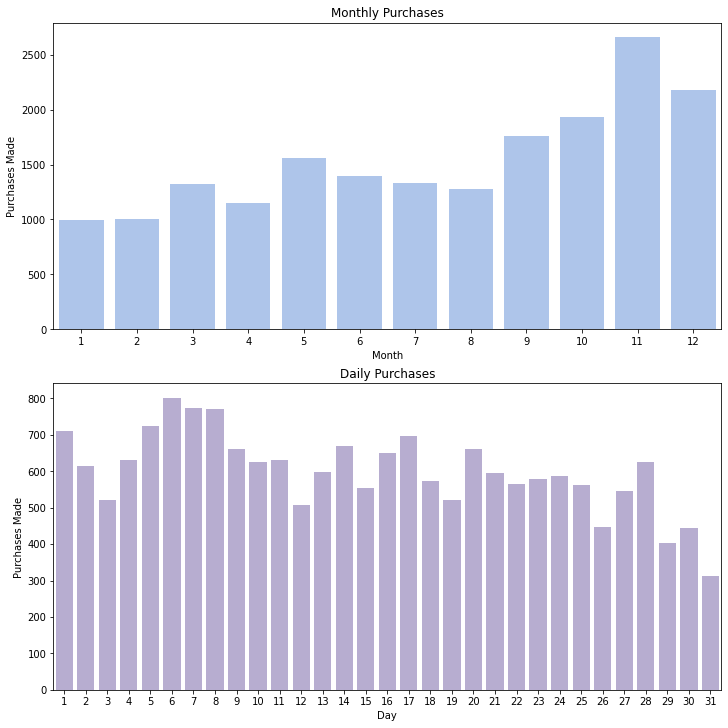

In [46]:
# Subplots by different time subsets.

fig, ax = plt.subplots(2,1, constrained_layout = True, figsize=(10,10))
sns.countplot(cust_df[['InvoiceNo','InvoiceDate']].drop_duplicates().InvoiceDate.dt.month, color ='#a4c2f4', ax=ax[0])
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Purchases Made')
ax[0].set_title('Monthly Purchases')

sns.countplot(cust_df[['InvoiceNo','InvoiceDate']].drop_duplicates().InvoiceDate.dt.day, color ='#b4a7d6', ax=ax[1])
ax[1].set_xlabel('Day')
ax[1].set_ylabel('Purchases Made')
ax[1].set_title('Daily Purchases')


The most popular months by the number of purchases have been September, November, December. There is no clear correlation among the days of the months and the times of purchases made.

In [47]:
#Purchases by Countries

In [68]:
#Top 5 countries by value
top_5_countries = trans_df['Country'].value_counts(normalize = True).head(5)

In [70]:
top_10_countries.head()

United Kingdom    0.914469
Germany           0.017195
France            0.015989
EIRE              0.015011
Spain             0.004723
Name: Country, dtype: float64

In [49]:
top_country = trans_df['Country'].value_counts(normalize = True).head(1)
print(f'The proportion of purchases made within a top country is: {top_country}')

The proportion of purchases made within a top country is: United Kingdom    0.914469
Name: Country, dtype: float64


More than 90% of all purchases has been made in the UK. Let's explore more about the UK customers

In [50]:
# Let us filter the united kingdom transactions with known customer IDs.
uk_df = trans_df[(trans_df['Country']=='United Kingdom') & (trans_df['CustomerID']!=-1)]
uk_df.reset_index(drop=True, inplace = True)

In [51]:
uk_df['UnitPrice'].describe()

count    349203.000000
mean          2.972328
std          17.990908
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

Around 75% of the products sold have price less than or equal to 3.75. The maximum price of the product sold is 25111.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='UnitPrice'>

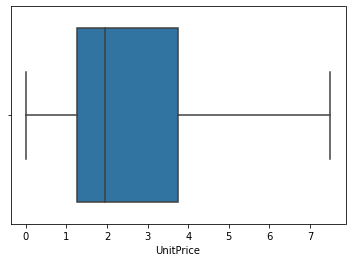

In [52]:
#plot a boxplot without statistical outliers
sns.boxplot(uk_df['UnitPrice'], showfliers = False)

In [53]:
# Making a dataframe of products less than 8 Pounds.
low_price_products = uk_df[uk_df['UnitPrice'] < 8]
low_price_products

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
349197,581585,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,2011-12-09 12:31:00,0.95,15804,United Kingdom,11.40
349198,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40
349199,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60
349200,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00


In [54]:
low_price_perc = uk_df[uk_df['UnitPrice']<=8].shape[0]/uk_df['UnitPrice'].shape[0]*100

print("{:.2f} % of the transactions made were less than 8 pounds.".format(low_price_perc))

93.64 % of the transactions made were less than 8 pounds.


In [55]:
low_price_rev = np.sum(uk_df[uk_df['UnitPrice']<=8].Revenue)/np.sum(uk_df.Revenue)*100

print("{:.2f} % of the revenue is contributed by those products.".format(low_price_rev))

89.07 % of the revenue is contributed by those products.


The majority of the revenue contributers are the transactions that cost less than 8 pounds. So the rest of them can affect the median price. 

In [56]:
#Customer classification: new/returned montly based

In [57]:
cust_type=uk_df.drop_duplicates(['InvoiceNo','CustomerID'])
cust_type.reset_index(drop=True, inplace = True)
cust_type.loc[:,'Type']=np.nan


for cust in cust_type['CustomerID'].unique():
    cust_type.loc[cust_type[cust_type['CustomerID']==cust].index,'Type']='Repeat'
    cust_type.loc[cust_type[cust_type['CustomerID']==cust].index[0],'Type']='New'

cust_type

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Type
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,New
1,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,Repeat
2,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,54.08,New
3,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50,Repeat
4,536369,21756,BATH BUILDING BLOCK WORD,3,2010-12-01 08:35:00,5.95,13047,United Kingdom,17.85,Repeat
...,...,...,...,...,...,...,...,...,...,...
16641,581582,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-09 12:21:00,2.08,17581,United Kingdom,12.48,Repeat
16642,581583,20725,LUNCH BAG RED RETROSPOT,40,2011-12-09 12:23:00,1.45,13777,United Kingdom,58.00,Repeat
16643,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,72,2011-12-09 12:25:00,0.72,13777,United Kingdom,51.84,Repeat
16644,581585,22481,BLACK TEA TOWEL CLASSIC DESIGN,12,2011-12-09 12:31:00,0.39,15804,United Kingdom,4.68,Repeat


# Explore main marketing metrics

# 1. Customer Retention and Customer Acquisition Rate

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Customer Retention Rate vs Customer Acquisition Rate')

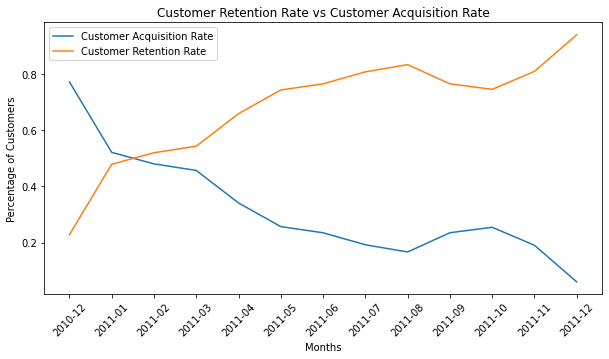

In [58]:
# Creating a new column for date time (Year-month)

cust_type.loc[:,'YM']=cust_type.InvoiceDate.dt.strftime("%Y-%m")

# Creating a dataframe from dictionary of monthly new and repeat customers

time = {}
for date in cust_type['YM'].unique():
    time[date]=(cust_type[cust_type['YM']==date].drop_duplicates(['CustomerID','Type'])['Type'].value_counts())
monthly_cust=pd.DataFrame(time).transpose()

#Plotting the line plot

plt.figure(figsize=(10,5))
plt.plot(monthly_cust['New']/(monthly_cust['New']+monthly_cust['Repeat']))
plt.plot(monthly_cust['Repeat']/(monthly_cust['New']+monthly_cust['Repeat']))
plt.legend(['Customer Acquisition Rate','Customer Retention Rate'])
plt.xlabel('Months')
plt.ylabel('Percentage of Customers')
plt.xticks(rotation = 45)
plt.title('Customer Retention Rate vs Customer Acquisition Rate')

In [59]:
#create data set about customer type in the UK only
join = pd.merge(uk_df, cust_type, how = 'inner', on = 'InvoiceNo')
join.head()

,InvoiceNo,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Revenue_x,StockCode_y,Description_y,Quantity_y,InvoiceDate_y,UnitPrice_y,CustomerID_y,Country_y,Revenue_y,Type,YM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,New,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,New,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,New,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,New,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.3,New,2010-12


(0.0, 1000.0)

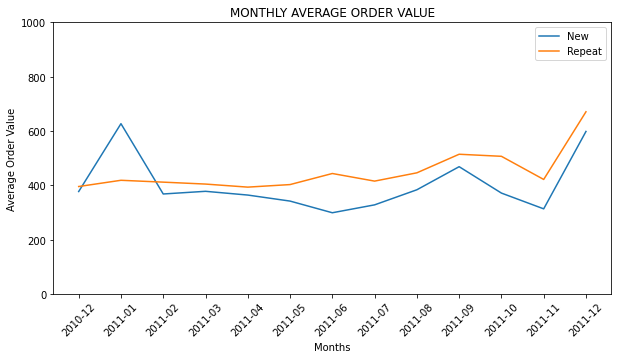

In [60]:
# Average Order Value
aov = (join.groupby(['YM','Type']).Revenue_x.sum().unstack()/join.groupby(['YM','Type']).InvoiceNo.nunique().unstack())
plt.figure(figsize=(10,5))
plt.plot(aov, )
plt.legend(['New', 'Repeat'])
plt.xlabel('Months')
plt.ylabel('Average Order Value')
plt.xticks(rotation = 45)
plt.title('MONTHLY AVERAGE ORDER VALUE')
plt.ylim(0,1000)

Text(0.5, 1.0, 'MONTHLY AVERAGE ORDER VALUE')

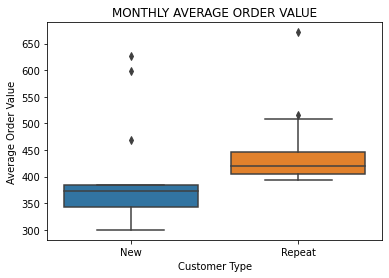

In [61]:
# Monthly Average Order Value (Barplot)
ym_type = join.groupby(['YM','Type']).Revenue_x.sum().unstack()/join.groupby(['YM','Type']).InvoiceNo.nunique().unstack()
sns.boxplot(x='Type', y='value', data = pd.melt(ym_type))
plt.xlabel('Customer Type')
plt.ylabel('Average Order Value')
plt.title('MONTHLY AVERAGE ORDER VALUE')

In [75]:
#Customer lifetime value (CLV)

In [76]:
#Av order size (AOS)
aos = join.Revenue_x.sum()/len(join['InvoiceNo'].unique())
print(f'The average bill value per transaction is: {aos}')

The average bill value per transaction is: 437.6441573951701


In [77]:
#Average Order Frequency (AOF)
aof = (len(join['InvoiceNo'].unique()))/(len(join['CustomerID_x'].unique()))
print(f'The average amount of orders placed by each customer is: {aof}')

The average amount of orders placed by each customer is: 4.246428571428571


In [78]:
#Average Customer Value (ACV)
acv = (aos*aof)
print("Average Customer Value Per Year is {:.2f} Pounds.".format(acv))

Average Customer Value Per Year is 1858.42 Pounds.


In [79]:
#Average Customer Lifespan (ACL)
total_days = np.sum((cust_type.groupby('CustomerID').InvoiceDate.max() - cust_type.groupby('CustomerID').InvoiceDate.min()).dt.days)
print(f'Total days: {total_days}')

Total days: 513603


In [80]:
#Total number of customers
total_cust = len(cust_type['CustomerID'].unique())
print(f'Total number of customers: {total_days}')

Total number of customers: 513603


In [81]:
acl = (total_days/total_cust)/365
print("Average Customer Lifespan Per Year is {:.2f}.".format(acl))

Average Customer Lifespan Per Year is 0.36.


In [82]:
#Customer Lifetime Value (CLV) in pounds
clv = acl*acv
print("Average Customer Lifetime Value is {:.2f}.".format(clv))

Average Customer Lifetime Value is 667.10.


Insight from CLT: The average cost of acquisition or average cost of serving one customer per year needs to be way below 667, in order to be profitable.

# CLV for Loyal Customer

In [84]:
# Calculating difference in max and min purchases dates for each customer
days_diff = (cust_type.groupby('CustomerID').InvoiceDate.max() - cust_type.groupby('CustomerID').InvoiceDate.min()).dt.total_seconds()
days_diff

CustomerID
12346           0.0
12747    31704960.0
12748    32225520.0
12749    18124260.0
12820    27916680.0
            ...    
18280           0.0
18281           0.0
18282    10274880.0
18283    28849680.0
18287    13733400.0
Name: InvoiceDate, Length: 3920, dtype: float64

In [85]:
cust_type.groupby('CustomerID').InvoiceDate.max()

CustomerID
12346   2011-01-18 10:01:00
12747   2011-12-07 14:34:00
12748   2011-12-09 12:20:00
12749   2011-12-06 09:56:00
12820   2011-12-06 15:12:00
                ...        
18280   2011-03-07 09:52:00
18281   2011-06-12 10:53:00
18282   2011-12-02 11:43:00
18283   2011-12-06 12:02:00
18287   2011-10-28 09:29:00
Name: InvoiceDate, Length: 3920, dtype: datetime64[ns]

In [86]:
# For repeat customers the difference between maximun and minimum purchase dates will not be zero
days_diff[days_diff != 0.0].index

Int64Index([12747, 12748, 12749, 12820, 12822, 12823, 12826, 12827, 12828,
            12829,
            ...
            18260, 18261, 18263, 18265, 18270, 18272, 18273, 18282, 18283,
            18287],
           dtype='int64', name='CustomerID', length=2567)

In [87]:
# Subsetting the dataframe for the above condition
repeat = join[~join['CustomerID_x'].isin(days_diff[days_diff == 0].index)]
repeat

,InvoiceNo,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Revenue_x,StockCode_y,Description_y,Quantity_y,InvoiceDate_y,UnitPrice_y,CustomerID_y,Country_y,Revenue_y,Type,YM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,New,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,New,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,New,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,New,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,New,2010-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349198,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40,22481,BLACK TEA TOWEL CLASSIC DESIGN,12,2011-12-09 12:31:00,0.39,15804,United Kingdom,4.68,Repeat,2011-12
349199,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,Repeat,2011-12
349200,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,Repeat,2011-12
349201,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,Repeat,2011-12


In [88]:
repeat_only = repeat[repeat['Type']=='Repeat']

In [89]:
repeat_only.head()

,InvoiceNo,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Revenue_x,StockCode_y,Description_y,Quantity_y,InvoiceDate_y,UnitPrice_y,CustomerID_y,Country_y,Revenue_y,Type,YM
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.1,Repeat,2010-12
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.1,Repeat,2010-12
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.5,Repeat,2010-12
22,536368,22913,RED COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,14.85,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.5,Repeat,2010-12
23,536368,22912,YELLOW COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,14.85,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.5,Repeat,2010-12


In [90]:
repeat_only

,InvoiceNo,StockCode_x,Description_x,Quantity_x,InvoiceDate_x,UnitPrice_x,CustomerID_x,Country_x,Revenue_x,StockCode_y,Description_y,Quantity_y,InvoiceDate_y,UnitPrice_y,CustomerID_y,Country_y,Revenue_y,Type,YM
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,Repeat,2010-12
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,Repeat,2010-12
21,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50,Repeat,2010-12
22,536368,22913,RED COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,14.85,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50,Repeat,2010-12
23,536368,22912,YELLOW COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047,United Kingdom,14.85,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.50,Repeat,2010-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349198,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40,22481,BLACK TEA TOWEL CLASSIC DESIGN,12,2011-12-09 12:31:00,0.39,15804,United Kingdom,4.68,Repeat,2011-12
349199,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,Repeat,2011-12
349200,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,Repeat,2011-12
349201,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,Repeat,2011-12


In [91]:
repeat_only.groupby(['CustomerID_x', 'InvoiceDate_x','InvoiceNo']).count()

StockCode_x  Description_x  \
CustomerID_x InvoiceDate_x       InvoiceNo                               
12747        2010-12-13 10:41:00 538537               8              8   
             2011-01-20 14:01:00 541677               5              5   
             2011-03-01 14:53:00 545321              12             12   
             2011-05-05 15:31:00 551992               9              9   
             2011-05-25 09:57:00 554549              14             14   
...                                                 ...            ...   
18283        2011-11-23 13:27:00 578262             102            102   
             2011-11-30 12:59:00 579673              50             50   
             2011-12-06 12:02:00 580872              50             50   
18287        2011-10-12 10:23:00 570715              38             38   
             2011-10-28 09:29:00 573167               3              3   

                                            Quantity_x  UnitPrice_x  \
CustomerID_x InvoiceDate_x       InvoiceNo                            
12747        2010-12-13 10:41:00 538537              8            8   
             2011-01-20 14:01:00 541677              5            5   
             2011-03-01 14:53:00 545321             12           12   
             2011-05-05 15:31:00 551992              9            9   
             2011-05-25 09:57:00 554549             14           14   
...                                                ...          ...   
18283        2011-11-23 13:27:00 578262            102          102   
             2011-11-30 12:59:00 579673             50           50   
             2011-12-06 12:02:00 580872             50           50   
18287        2011-10-12 10:23:00 570715             38           38   
             2011-10-28 09:29:00 573167              3            3   

                                            Country_x  Revenue_x  StockCode_y  \
CustomerID_x InvoiceDate_x       InvoiceNo                                      
12747        2010-12-13 10:41:00 538537             8          8            8   
             2011-01-20 14:01:00 541677             5          5            5   
             2011-03-01 14:53:00 545321            12         12           12   
             2011-05-05 15:31:00 551992             9          9            9   
             2011-05-25 09:57:00 554549            14         14           14   
...                                               ...        ...          ...   
18283        2011-11-23 13:27:00 578262           102        102          102   
             2011-11-30 12:59:00 579673            50         50           50   
             2011-12-06 12:02:00 580872            50         50           50   
18287        2011-10-12 10:23:00 570715            38         38           38   
             2011-10-28 09:29:00 573167             3          3            3   

                                            Description_y  Quantity_y  \
CustomerID_x InvoiceDate_x       InvoiceNo                              
12747        2010-12-13 10:41:00 538537                 8           8   
             2011-01-20 14:01:00 541677                 5           5   
             2011-03-01 14:53:00 545321                12          12   
             2011-05-05 15:31:00 551992                 9           9   
             2011-05-25 09:57:00 554549                14          14   
...                                                   ...         ...   
18283        2011-11-23 13:27:00 578262               102         102   
             2011-11-30 12:59:00 579673                50          50   
             2011-12-06 12:02:00 580872                50          50   
18287        2011-10-12 10:23:00 570715                38          38   
             2011-10-28 09:29:00 573167                 3           3   

                                            InvoiceDate_y  UnitPrice_y  \
CustomerID_x InvoiceDate_x       InvoiceNo                               
12747

In [92]:
#filter InvoiceNo >5 purchases
repeat_only.InvoiceNo.count()>5

True

In [93]:
# Average Order Size (Repeat: aos_r)
aos_r = repeat.Revenue_x.sum()/len(repeat['CustomerID_x'].unique())
print("Average Order Size of Repeat Customer is {:.2f}.".format(aos_r))

Average Order Size of Repeat Customer is 2634.94.


In [94]:
# Average Order Frequency (Repeat: aof_r)
aof_r = (len(repeat['InvoiceNo'].unique()))/(len(repeat['CustomerID_x'].unique()))
print("Average Order Frequency of Repeat Customer is {:.2f}.".format(aof_r))

Average Order Frequency of Repeat Customer is 5.96.


In [95]:
# Average Customer Value (Repeat: acv_r)
acv_r = (aos_r * aof_r)
print("Average Repeat Customer Value is {:.2f}.".format(acv_r))

Average Repeat Customer Value is 15694.70.


In [96]:
total_days_n = np.sum((repeat.groupby('CustomerID_x').InvoiceDate_x.max() - repeat.groupby('CustomerID_x').InvoiceDate_x.min()).dt.days)
print(f'Total days: {total_days_n}')

Total days: 513603


In [97]:
repeat_len = len((repeat.groupby('CustomerID_x').InvoiceDate_x.max() - repeat.groupby('CustomerID_x').InvoiceDate_x.min()).dt.days)
repeat_len

2567

In [98]:
# Average Customer Lifetime (Repeat: acl_r)
acl_r = (total_days_n/repeat_len)/365
print("Average Repeat Customer Lifespan is {:.2f}.".format(acl_r))

Average Repeat Customer Lifespan is 0.55.


In [99]:
# Average Customer Lifetime Value (Repeat: clv_r)
clv_r = acv_r * acl_r
print("Average Repeat Customer Lifetime Value is {:.2f}.".format(clv_r))

Average Repeat Customer Lifetime Value is 8603.24.


Average Customer Lifetime Value is 667.10 and Average Repeat Customer Lifetime Value is 8603.24. So for our cutomer activities is better to concentrate on repeat cusomers because their CLV more than 10 times higher. 
Insight from the data analysis: in our fiture strategy we need to concentrate on customer retantion.

# Forecasting in the UK

In [100]:
#prepare data for time series analysis setting Invoice data as an index
uk_df['InvoiceDate'] = pd.to_datetime(uk_df['InvoiceDate'])
uk_df.set_index('InvoiceDate', inplace = True)

uk_df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Revenue
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34


Text(0.5, 1.0, 'UK weekly Total Revenue')

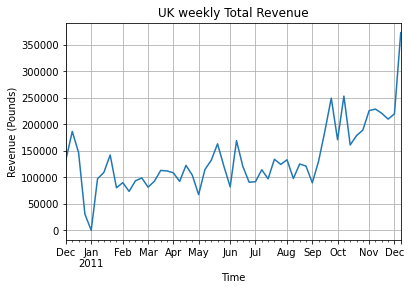

In [101]:
# weekly Revenue Sum
uk_df.resample('1W').Revenue.sum().plot(grid = True)
plt.xlabel('Time')
plt.ylabel('Revenue (Pounds)')
plt.title('UK weekly Total Revenue')

Text(0.5, 1.0, 'UK weekly Total Revenue')

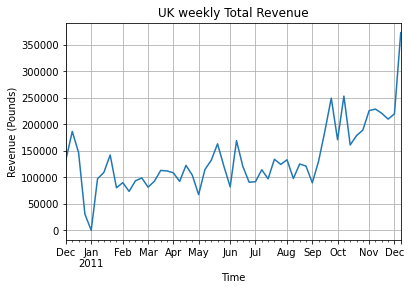

In [102]:
# weekly Revenue Sum
uk_df.resample('1W').Revenue.sum().plot(grid = True)
plt.xlabel('Time')
plt.ylabel('Revenue (Pounds)')
plt.title('UK weekly Total Revenue')

Text(0, 0.5, 'Number of Unique Transactions')

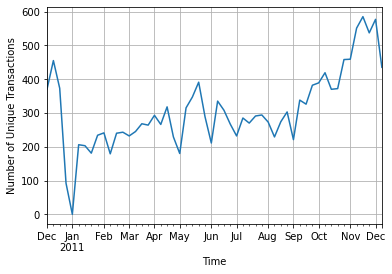

In [103]:
# weekly Number of Unique Transactions
uk_df.resample('1W').InvoiceNo.nunique().plot(grid = True)
plt.xlabel('Time')
plt.ylabel('Number of Unique Transactions')

In [104]:
uk_dfts = uk_df.resample('1W').Revenue.sum().loc['2010':'2011']

Text(0.5, 1.0, 'UK weekly Total Revenue')

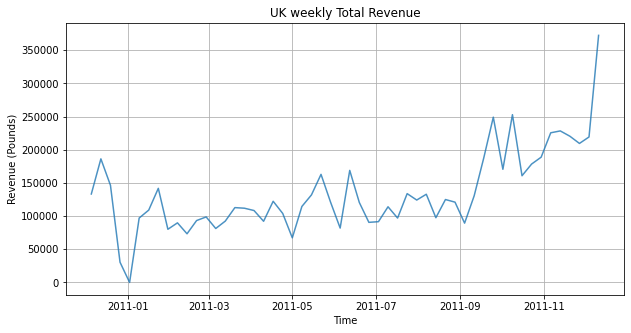

In [105]:
# weekly Revenue Sum

plt.figure(figsize = (10,5))
train = uk_dfts[:26]
test = uk_dfts[26:]
plt.plot(uk_dfts, alpha = 0.8)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Revenue (Pounds)')
plt.title('UK weekly Total Revenue')

From the revemue graph we can see some seasonality that starts after September and we can also observe few spikes in May and June. 

In [106]:
uk_df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Revenue
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34


In [107]:
uk_clean = uk_df.drop(['StockCode', 'Description', 'Country'], axis = 1)

In [108]:
uk_clean.head()

,InvoiceNo,Quantity,UnitPrice,CustomerID,Revenue
InvoiceDate,,,,,
2010-12-01 08:26:00,536365,6,2.55,17850,15.30
2010-12-01 08:26:00,536365,6,3.39,17850,20.34
2010-12-01 08:26:00,536365,8,2.75,17850,22.00
2010-12-01 08:26:00,536365,6,3.39,17850,20.34
2010-12-01 08:26:00,536365,6,3.39,17850,20.34


In [113]:
uk_clean.reset_index(inplace=True)

In [110]:
pip install lifetimes

     |████████████████████████████████| 584 kB 3.1 MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47990 sha256=0eee4c3a864db604c9cd96179f1bc2b247b34159acc15cc1c07b5c627e2051e1
  Stored in directory: /Users/liubovivashov/Library/Caches/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd
Note: you may need to restart the kernel to use updated packages.


In [111]:
import lifetimes

# RFM Estimation - (Recency, Frequency, Monetary)

In [114]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(uk_clean, "CustomerID", "InvoiceDate", "Revenue")

In [115]:
rfm_summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12747,10.0,367.0,369.0,383.745000
12748,112.0,373.0,373.0,295.073571
12749,3.0,210.0,213.0,1077.260000
12820,3.0,323.0,326.0,257.293333


In [116]:
rfm_summary.reset_index(inplace = True)

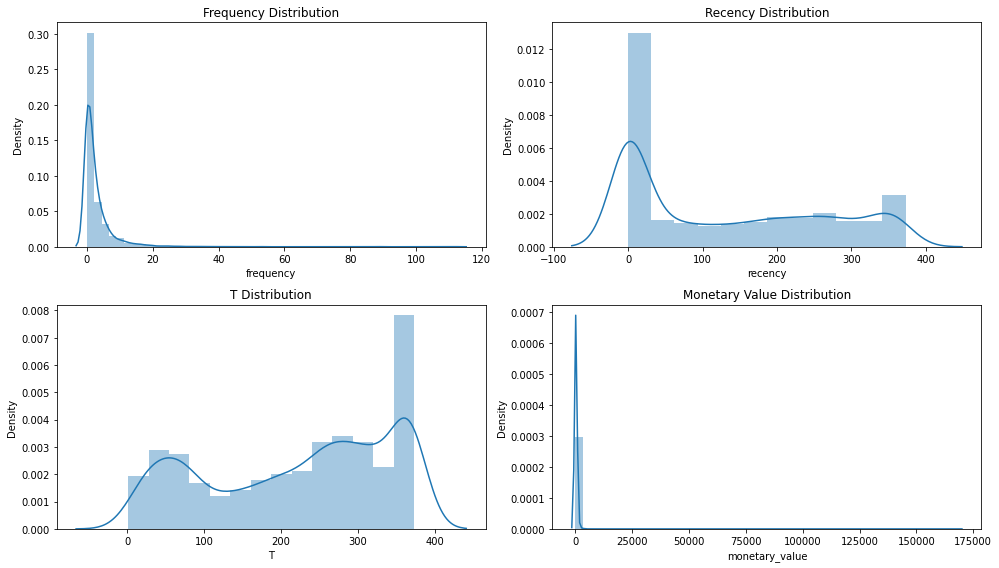

In [117]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

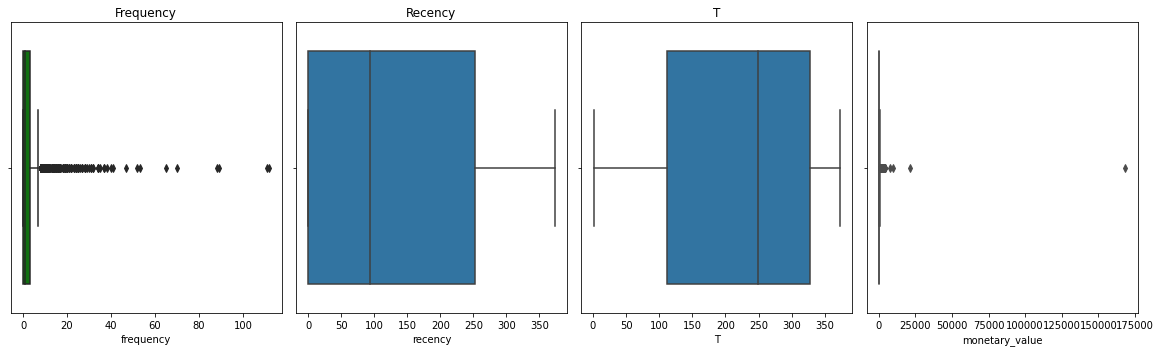

In [118]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "green")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "blue")

plt.tight_layout()

In [119]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000
mean,15562.059694,2.850000,131.343622,223.085714,292.041479
std,1576.594671,5.713358,132.443948,118.037855,2734.851885
min,12346.000000,0.000000,0.000000,1.000000,0.000000
1%,12867.190000,0.000000,0.000000,10.000000,0.000000
10%,13357.900000,0.000000,0.000000,45.000000,0.000000
25%,14208.750000,0.000000,0.000000,112.000000,0.000000
50%,15569.500000,1.000000,94.000000,249.000000,172.703333
75%,16913.250000,3.000000,252.000000,327.000000,347.227500
90%,17735.100000,7.000000,340.000000,367.000000,546.412333


Not a big difference between 90 and 99 percentile.

# Pareto and NBD model

In [124]:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt

In [128]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='green',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")


Predicted Purchase Mean Squared Error: 2.6891594735938393
Predicted Purchase R2 Score: 0.08213406829293468
Predicted Purchase Root Mean Squared Error: 1.6398656876689137
Predicted Purchase Average Purchases Error: 0.2200989145236519


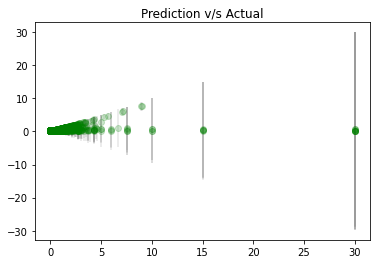

In [129]:
get_model(rfm_summary, 0.001, 30)

Based on the above errors, we have found that penalizer_coef = 0.1 is doing slightly better at minimizing the errors so we will be using 0.1 for our model.

In [130]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [131]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 3920 subjects, alpha: 69.78, beta: 0.02, r: 0.83, s: 0.00>

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

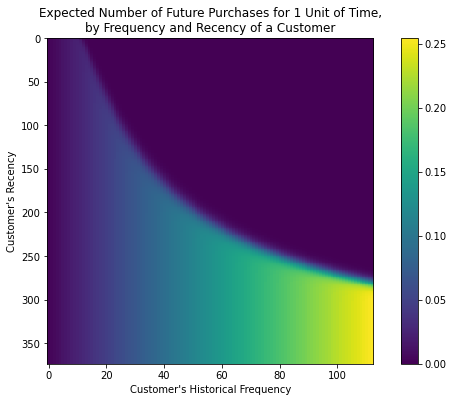

In [132]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

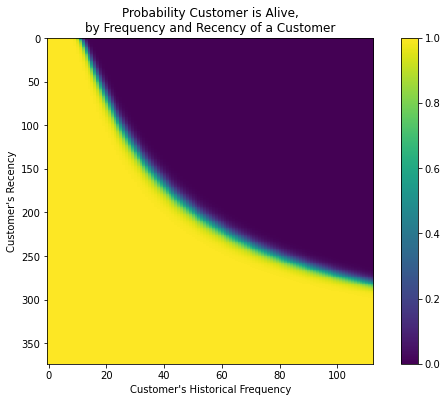

In [133]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [134]:
pareto_result = rfm_summary.copy()

In [135]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [136]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,0.0,0.0,325.0,0.000000,1.036962e-08,1.0
1,12747,10.0,367.0,369.0,383.745000,1.676659e-12,1.0
2,12748,112.0,373.0,373.0,295.073571,0.000000e+00,1.0
3,12749,3.0,210.0,213.0,1077.260000,4.356737e-12,1.0
4,12820,3.0,323.0,326.0,257.293333,2.822853e-12,1.0


In [162]:
t = 10 #predict purchases in 10 periods
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [163]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,0.0,0.0,325.0,0.000000,1.036962e-08,1.0,0.019012,0.000000,-0.063064
1,12747,10.0,367.0,369.0,383.745000,1.676659e-12,1.0,0.248859,0.817439,0.076991
2,12748,112.0,373.0,373.0,295.073571,0.000000e+00,1.0,2.589075,9.008043,1.363474
3,12749,3.0,210.0,213.0,1077.260000,4.356737e-12,1.0,0.135662,0.428571,0.022266
4,12820,3.0,323.0,326.0,257.293333,2.822853e-12,1.0,0.096196,0.278638,-0.011664
...,...,...,...,...,...,...,...,...,...,...
3915,18280,0.0,0.0,277.0,0.000000,9.266322e-09,1.0,0.021700,0.000000,-0.071793
3916,18281,0.0,0.0,180.0,0.000000,6.943710e-09,1.0,0.030383,0.000000,-0.099673
3917,18282,1.0,119.0,126.0,77.840000,1.778599e-11,1.0,0.092159,0.252101,-0.028293
3918,18283,13.0,334.0,337.0,149.006154,2.833289e-12,1.0,0.343903,1.167665,0.147722


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

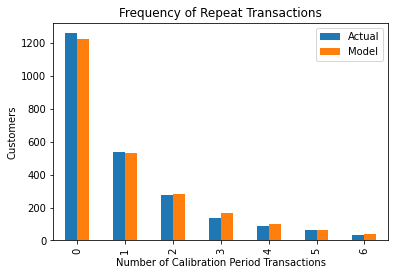

In [164]:
plot_period_transactions(pareto_model)

In [165]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(uk_clean, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [166]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,141.0,0.0,184.0
12747,5.0,171.0,185.0,5.0,184.0
12748,42.0,188.0,189.0,69.0,184.0
12749,0.0,0.0,29.0,3.0,184.0
12820,0.0,0.0,142.0,3.0,184.0


In [167]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 2516 subjects, alpha: 62.53, beta: 653.41, r: 0.74, s: 0.00>

In [168]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

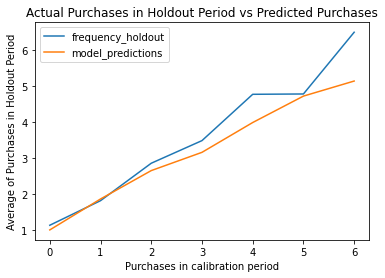

In [169]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [170]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,141.0,0.0,184.0
12747,5.0,171.0,185.0,5.0,184.0
12748,42.0,188.0,189.0,69.0,184.0
12749,0.0,0.0,29.0,3.0,184.0
12820,0.0,0.0,142.0,3.0,184.0


In [171]:
pareto_result["actual10"] = pareto_result["frequency"]/pareto_result["recency"]*10

In [172]:
pareto_result["actual10"].fillna(0, inplace = True)

In [173]:
pareto_result["error"] = pareto_result["actual10"]-pareto_result["predicted_purchases"]

In [174]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,actual10
0,12346,0.0,0.0,325.0,0.000000,1.036962e-08,1.0,0.019012,0.000000,-0.019012,0.000000
1,12747,10.0,367.0,369.0,383.745000,1.676659e-12,1.0,0.248859,0.817439,0.023620,0.272480
2,12748,112.0,373.0,373.0,295.073571,0.000000e+00,1.0,2.589075,9.008043,0.413606,3.002681
3,12749,3.0,210.0,213.0,1077.260000,4.356737e-12,1.0,0.135662,0.428571,0.007195,0.142857
4,12820,3.0,323.0,326.0,257.293333,2.822853e-12,1.0,0.096196,0.278638,-0.003317,0.092879


In [180]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "green")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 0.29812246783960605
Root Mean Squared Error: 0.5460059228979169
R2 Score: 0.0842015378632589


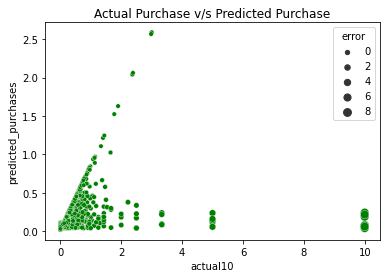

In [181]:
get_metrics(pareto_result["actual10"], pareto_result["predicted_purchases"], pareto_result["error"])

# GAMMA-GAMMA MODEL

we have to remove the values with 0 frequency and monetary values

In [186]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [187]:
idx = idx.index

In [188]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [189]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [190]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [191]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

<AxesSubplot:>

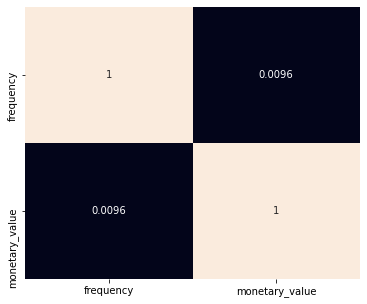

In [192]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [193]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [194]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 1.03, q: 0.18, v: 0.93>

In [195]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.034609,0.031424,0.973017,1.096201
q,0.179749,0.003881,0.172142,0.187357
v,0.933029,0.032831,0.868681,0.997377


In [196]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [197]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,actual10,expected_avg_sales_
1,12747,10.0,367.0,369.0,383.745000,1.676659e-12,1.0,0.248859,0.817439,0.023620,0.272480,416.889837
2,12748,112.0,373.0,373.0,295.073571,0.000000e+00,1.0,2.589075,9.008043,0.413606,3.002681,297.185584
3,12749,3.0,210.0,213.0,1077.260000,4.356737e-12,1.0,0.135662,0.428571,0.007195,0.142857,1464.629789
4,12820,3.0,323.0,326.0,257.293333,2.822853e-12,1.0,0.096196,0.278638,-0.003317,0.092879,350.134693
6,12822,1.0,17.0,87.0,257.980000,9.679815e-10,1.0,0.116212,1.764706,0.472023,0.588235,1249.653721


In [198]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 168470449.44483253
Root Mean Squared Error: 12979.61669098254
R2 Score: -13.587487971646135


In [199]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [201]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
2598,16446,4.088880e+06
3783,18102,4.479490e+05
3314,17450,3.677859e+05
2094,15749,3.544504e+05
902,14096,3.394592e+05


In [202]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [203]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [204]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

# CUSTOMER SEGMENTATION USING PREDICTED CLV

In [205]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,actual10,expected_avg_sales_,predicted_clv,profit_margin
1,12747,10.0,367.0,369.0,383.745000,1.676659e-12,1.0,0.248859,0.817439,0.023620,0.272480,416.889837,8031.315927,401.565796
2,12748,112.0,373.0,373.0,295.073571,0.000000e+00,1.0,2.589075,9.008043,0.413606,3.002681,297.185584,59559.056829,2977.952841
3,12749,3.0,210.0,213.0,1077.260000,4.356737e-12,1.0,0.135662,0.428571,0.007195,0.142857,1464.629789,15382.249413,769.112471
4,12820,3.0,323.0,326.0,257.293333,2.822853e-12,1.0,0.096196,0.278638,-0.003317,0.092879,350.134693,2607.786710,130.389335
6,12822,1.0,17.0,87.0,257.980000,9.679815e-10,1.0,0.116212,1.764706,0.472023,0.588235,1249.653721,11242.860514,562.143026


In [206]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

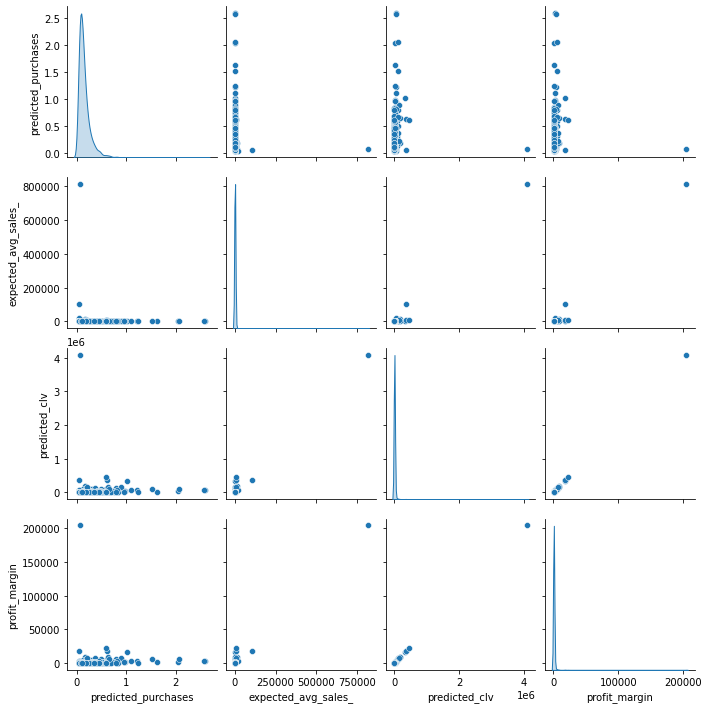

In [207]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [208]:
new_df = ggf_filter[col]

In [209]:
inertia = []

for i in range(2, 11):
    cluster = KMeans(n_clusters = i, init = "k-means++").fit(new_df)
    inertia.append(cluster.inertia_)

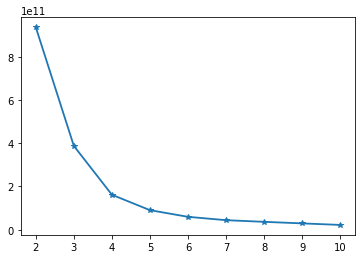

In [210]:
plt.figure(figsize=(6,4))
plt.plot(range(2,11), inertia, marker = "*", linewidth = 1.8)

In [211]:
k_model = KMeans(n_clusters = 4, init = "k-means++", n_jobs = -1, max_iter = 1000)

In [212]:
k_model_fit = k_model.fit(new_df)

In [213]:
new_df

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
1,0.248859,416.889837,8031.315927,401.565796
2,2.589075,297.185584,59559.056829,2977.952841
3,0.135662,1464.629789,15382.249413,769.112471
4,0.096196,350.134693,2607.786710,130.389335
6,0.116212,1249.653721,11242.860514,562.143026
...,...,...,...,...
3909,0.185992,579.886883,8349.195470,417.459774
3910,0.085670,127.513736,845.830731,42.291537
3917,0.092159,380.201063,2712.995784,135.649789
3918,0.343903,158.759991,4226.410221,211.320511


In [214]:
centers = k_model_fit.cluster_centers_

In [215]:
centers

array([[1.51331008e-01, 7.89535883e+02, 7.08262004e+03, 3.54131002e+02],
       [6.49352696e-02, 8.13129526e+05, 4.08888029e+06, 2.04444015e+05],
       [5.72504664e-01, 3.13797760e+04, 3.77411109e+05, 1.88705555e+04],
       [6.31105151e-01, 4.02355312e+03, 8.56673414e+04, 4.28336707e+03]])

In [216]:
labels = k_model_fit.labels_

In [217]:
labels = pd.Series(labels, name = "Labels")

In [218]:
ggf_filter = pd.concat([ggf_filter, labels], axis = 1)

In [219]:
label_mapper = dict({0 : "Low", 3: "Medium", 1: "High", 2: "V_High"})

In [220]:
ggf_filter["Labels"] = ggf_filter["Labels"].map(label_mapper)

In [221]:
ggf_filter.groupby("Labels").mean().T

Labels,High,Low,Medium,V_High
CustomerID,1.518400e+04,1.456485e+04,1.434673e+04,1.510100e+04
frequency,1.000000e+00,4.446260e+00,3.884615e+00,3.750000e+00
recency,1.610000e+02,2.034588e+02,2.017692e+02,2.552500e+02
T,1.900000e+02,2.593526e+02,2.592692e+02,2.812500e+02
monetary_value,1.669700e+02,4.028524e+02,3.177734e+02,4.386155e+02
p_not_alive,5.569101e-11,5.179236e-10,4.324070e-10,4.472989e-11
p_alive,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
predicted_purchases,6.879385e-02,1.597049e-01,1.504287e-01,1.436509e-01
actual30,1.863354e-01,8.538173e-01,8.243090e-01,5.440421e-01
error,-6.682046e-03,1.249008e-01,1.243409e-01,3.769640e-02


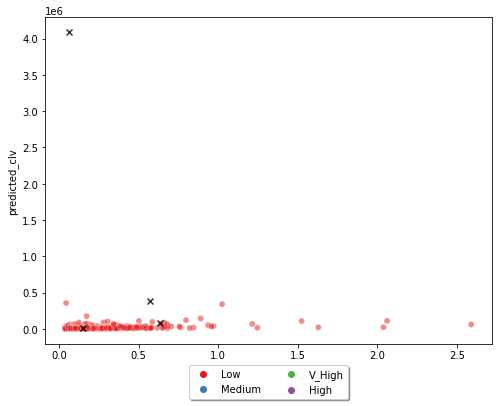

In [222]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = "predicted_purchases", y = "predicted_clv", hue = "Labels", palette = "Set1", data = ggf_filter, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 2], marker = "x", color = "k", alpha = 0.8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)